











[  9. -24.  -2.   0.]
Final pose [  7.54 -22.64  -2.    -0.01]


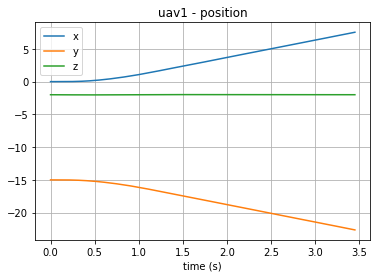

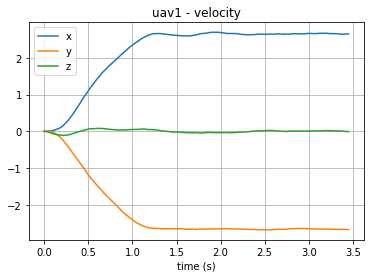

In [11]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
import numpy as np
from IPython.display import HTML, display

sys.path.insert(0, '../')
from flightgoggles.env import *

if __name__ == "__main__":
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSim.yaml") # 30 max_speed multicopterDynamicsSimSpeed

    start_pos = np.array([0, -15., -2.])
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = start_pos,
                          attitude_euler_angle=np.array([0.,0.,-np.pi/2]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"]
    curr_vel = env.get_state("uav1")["velocity"]
    
    target_pose = np.zeros(4)
    target_pose[:3] = curr_pos + np.array([9.0,-9.0,0.0])
    target_pose[3] = curr_att[2] + np.pi/2
    
    att_accumulator = np.array([curr_att[2]])
    
    waypoint_num = 5
    x_vals = np.linspace(start_pos[0], target_pose[0], num=waypoint_num)
    y_vals = np.linspace(start_pos[1], target_pose[1], num=waypoint_num)
    z_vals = np.linspace(start_pos[2], target_pose[2], num=waypoint_num)
    att_vals = np.linspace(curr_att[2], target_pose[3], num=waypoint_num)
    
    path_coords = np.vstack((x_vals, y_vals, z_vals, att_vals))
    
    EPSILON = 2
    stop = False
    for column in path_coords.T:
        # print("Heading to ", column, ", from ", curr_pos)
        while np.linalg.norm(curr_pos - column[:3]) > EPSILON:
            collided = env.speed_to_waypoint(vehicle_id="uav1",
                                          waypoint_command=column,
                                          duration=0.01)
            curr_pos = env.get_state("uav1")["position"]
            curr_vel = env.get_state("uav1")["velocity"]
            att_accumulator = np.append(att_accumulator, env.get_state("uav1")["attitude_euler_angle"][2])
            if collided:
                stop = True
                break
        if stop:
            break
    
    print("Target pose", target_pose)
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))
    
    env.plot_state(vehicle_id="uav1", attribute="position")
    env.plot_state(vehicle_id="uav1", attribute="velocity")

    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=400)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()

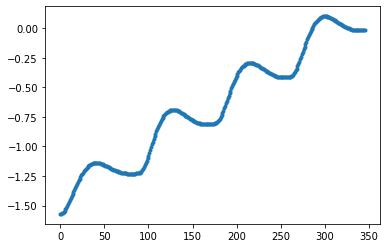

In [12]:
import matplotlib.pyplot as plt

x = np.arange(att_accumulator.size)
y = att_accumulator
plt.plot(x, y, marker='.')